# Build Stoichiometry-Based Resistance Model

Inspect the impact of shifting cathode stoichiometry on the decrease in low-SOC resistance using a toy model.

Created: 06/08/2021

Author:  Andrew Weng

- 6/19/2021
  - included plot of voltage curves before formation
  - focus plots in low SOC regions
  - expanded resistance covers to cover negative capacity values

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import json

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scipy import interpolate
from matplotlib import pyplot as plt

from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
CELL_BASE = 4 # baseline high temperature
CELL_FAST = 33 # fast formation high temperature

# Some physical limits
MIN_VOLTAGE = 3.0
MAX_VOLTAGE = 4.2

In [5]:
# Plot aesthetics
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL = np.array([0, 0, 0])

COLOR_BG = (0.2, 0.2, 0.2)
COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

figsize = (9, 5.5)

## Process data before formation
- reference `src/plot_voltage_curves_before_formation.m` for the generation process

(0.0, 4.5)

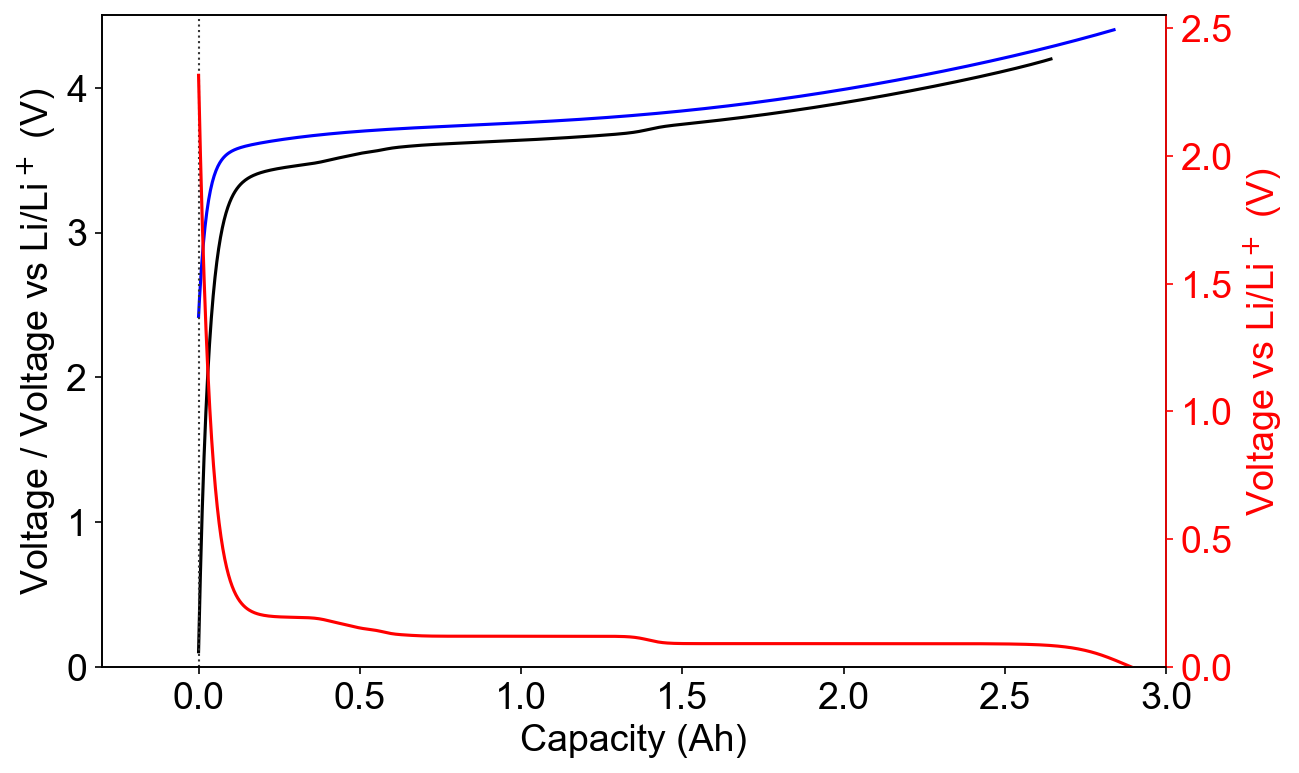

In [6]:
file_name_voltage_data_before_formation = 'output/voltage_curves_before_formation.json'

with open(file_name_voltage_data_before_formation) as f:
    data = json.load(f)
    

fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()

ax.plot(data['q_pos'], data['v_pos'], color=COLOR_POS, linestyle='-')
ax.plot(data['q_full'], data['v_full'], color=COLOR_FULL, linestyle='-')
ax2.plot(data['q_neg'], data['v_neg'], color=COLOR_NEG, linestyle='-')

ax.plot([0, 0], [0, 4.5], color=COLOR_BG, linestyle=':', linewidth=1)

ax.set_xlabel('Capacity (Ah)')
ax2.yaxis.label.set_color(COLOR_NEG)
ax2.spines["right"].set_edgecolor(COLOR_NEG)
ax2.tick_params(axis='y', colors=COLOR_NEG)

ax.set_ylabel('Voltage / Voltage vs Li/Li$^+$ (V)')
ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
ax.set_xlim((-0.3, 3))
ax2.set_ylim((0, 2.55))
ax.set_ylim((0, 4.5))


## Process data from the formation tests

In [7]:
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

In [8]:
summary_stats = cell_dict[CELL_FAST].get_formation_test_summary_statistics()
q_lli_ah_ref = summary_stats['form_first_charge_capacity_ah'] - summary_stats['form_final_discharge_capacity_ah']

In [9]:
# Data from cells
df_hppc_1 = cell_dict[CELL_FAST].process_diagnostic_hppc_discharge_data()[0]['data']
df_hppc_3 = cell_dict[CELL_BASE].process_diagnostic_hppc_discharge_data()[0]['data']

df_esoh_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
df_esoh_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[2]
df_esoh_3 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
df_esoh_4 = cell_dict[CELL_BASE].get_esoh_fitting_data()[3]

In [10]:
INTERP_KIND = 'linear' # try 'linear', 'cubic', 'quadratic'

# Unpack the data
capacity = df_hppc_1['capacity']
soc = capacity / np.max(capacity) * 100

# Build a higher fidelity, smooth signal for the toy model
resistance = df_hppc_1['resistance_10s_ohm']
capacity_hifi = np.linspace(np.min(capacity), np.max(capacity), 300)
interp_fn = interpolate.interp1d(capacity, resistance, kind=INTERP_KIND)
resistance_hifi = interp_fn(capacity_hifi)
soc_hifi = capacity_hifi / np.max(capacity_hifi) * 100

In [11]:
def compute_resistance_curves(capacity_vec, 
                              resistance_vec, 
                              frac_cathode_resistance=0.7, 
                              capacity_shift_ah=0,
                              resistance_growth_rate=0, 
                              adjust_for_resistance_change=False, 
                              swap_cathode_anode=False,
                              split_proportionally=False):
    """
    Create a data set consisting of pos, neg, and full cell resistance curves
    
    Parameters
    ---------
    capacity_vec (np.array)
      vector of capacity for full cell
      
    resistance_vec (np.array)
      vector of resistance for full cell in Ohms
      
    frac_cathode_rct (0-1)
      fraction of total measured resistance attributed to cathode charge tranfser
      
    capacity_shift_ah (float)
      capacity corresponding to extra lithium lithium lost to SEI during formation
    
    resistance_growth_rate (float)
      SEI resistance growth per Ah of Li
      
    adjust_for_resistance_change (boolean)
      if True then will make an additional adjustment to the curve to account for
      intrinsic resistance growth
      
    swap_cathode_anode (boolean)
      if True then swap the cathode and anode resistance curves (for sensitivity analysis)
      
    split_proportionally (boolean)
      if True then split the resistance proportionally between cathode and anode 
      based on frac_cathode_resistance
      
    
    Outputs
    ---------
    a dictionary containing:
    
      capacity_expanded
        an updated capacity vector that matches the dimensions of the shifted resistances
        
      resistance_full_modeled
        modeled full cell resistance after shifting (Ohms)
        
      resistance_cathode
        modeled cathod charge transfer resistance (Ohms)
        
      resistance_other
        modeled 'other' resistance (Ohms)
        
    
    Invariants
    ---------
    
    resistance_other + resistance_cathode_shifted = resistance_full_modeled
    
    """
        
    # Definition of "base" resistance
    capacity_threshold = 1 
    resistance_base = np.min(resistance_vec[capacity_vec < capacity_threshold])

    # Reference resistance (intermediate step for constructing cathode resistance)
    resistance_ref = (1 - frac_cathode_resistance) * resistance_base * np.ones(np.size(resistance_vec))
    
    # Construct the cathode charge transfer resistance curve
    # Assumes:
    # - Cathode inherits all of the resistances at low capacities up to some reference point
    # - Cathode resistance flattens out after the capacity threshold
    resistance_cathode = resistance_vec - resistance_ref
    resistance_cathode[capacity_vec > capacity_threshold] = \
       resistance_cathode[capacity_vec <= capacity_threshold][-1]

    # Definition of R_other
    resistance_other = resistance_vec - resistance_cathode

    # Define shifted cathode charge transfer resistance

    # Shifting the resistance curve!
    
    # Expand the the capacity vector to include negative values
    cap_vec_min = 0
    cap_vec_max = np.max(capacity_vec)
    cap_vec_diff = np.diff(capacity_vec)[0]
    
    capacity_vec_expanded = np.arange(cap_vec_min, cap_vec_max + cap_vec_diff, cap_vec_diff)
        
    fn = interpolate.interp1d(capacity_vec, resistance_cathode, bounds_error=False, fill_value='extrapolate')
    resistance_cathode_shifted = fn(capacity_vec_expanded + capacity_shift_ah)
    
    fn2 = interpolate.interp1d(capacity_vec, resistance_other, bounds_error=False, fill_value='extrapolate')
    resistance_other_expanded = fn2(capacity_vec_expanded)
    
    if adjust_for_resistance_change:        
        # Attribute the resistance growth to the anode (but it could come from either, it doesn't matter)
        resistance_other += resistance_growth_rate * capacity_shift_ah
        
    # Calculated the shifted full cell resistance
    resistance_full_modeled = resistance_other_expanded + resistance_cathode_shifted
    
    # Assert invariants hold
#     assert np.all(resistance_cathode_shifted + resistance_other_expanded == resistance_full_modeled)
    
    output = dict()
    output['resistance_full_modeled'] = resistance_full_modeled
    
    output['capacity_expanded'] = capacity_vec_expanded
    output['resistance_cathode'] = resistance_cathode_shifted
    output['resistance_other'] = resistance_other_expanded
    
    if swap_cathode_anode:
        output['resistance_cathode'] = resistance_other_expanded
        output['resistance_other'] = resistance_cathode_shifted
        
    if split_proportionally:
        output['resistance_cathode'] = resistance_full_modeled * frac_cathode_resistance
        output['resistance_other'] = resistance_full_modeled * (1 - frac_cathode_resistance)
    
    return output

### Initialize the dataset to plot

In [12]:
# Define the horizontal leftward cathode capacity shift for this toy model demonstration
capacity_shift_ah = 0.1
capacity_shift_ah = np.array(capacity_shift_ah)

capacity_at_5_soc = 0.05 * np.max(capacity_hifi)

q_pos = df_esoh_1['pos']['Q']
q_neg = df_esoh_1['neg']['Q']
v_pos = df_esoh_1['pos']['V']
v_neg = df_esoh_1['neg']['V']
q_full = df_esoh_1['orig']['Q']
v_full = df_esoh_1['orig']['V']

# Percentage of total cell resistance attributed to the cathode charge transfer resistance
frac_cathode_rct = 0.7

# Fast formation
fast = compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                   frac_cathode_rct, capacity_shift_ah, 0, False)

# Baseline formation
base = compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                     frac_cathode_rct, 0, 0, False)


### Make the plot of voltage curve alignment 
Compare between baseline and fast formation

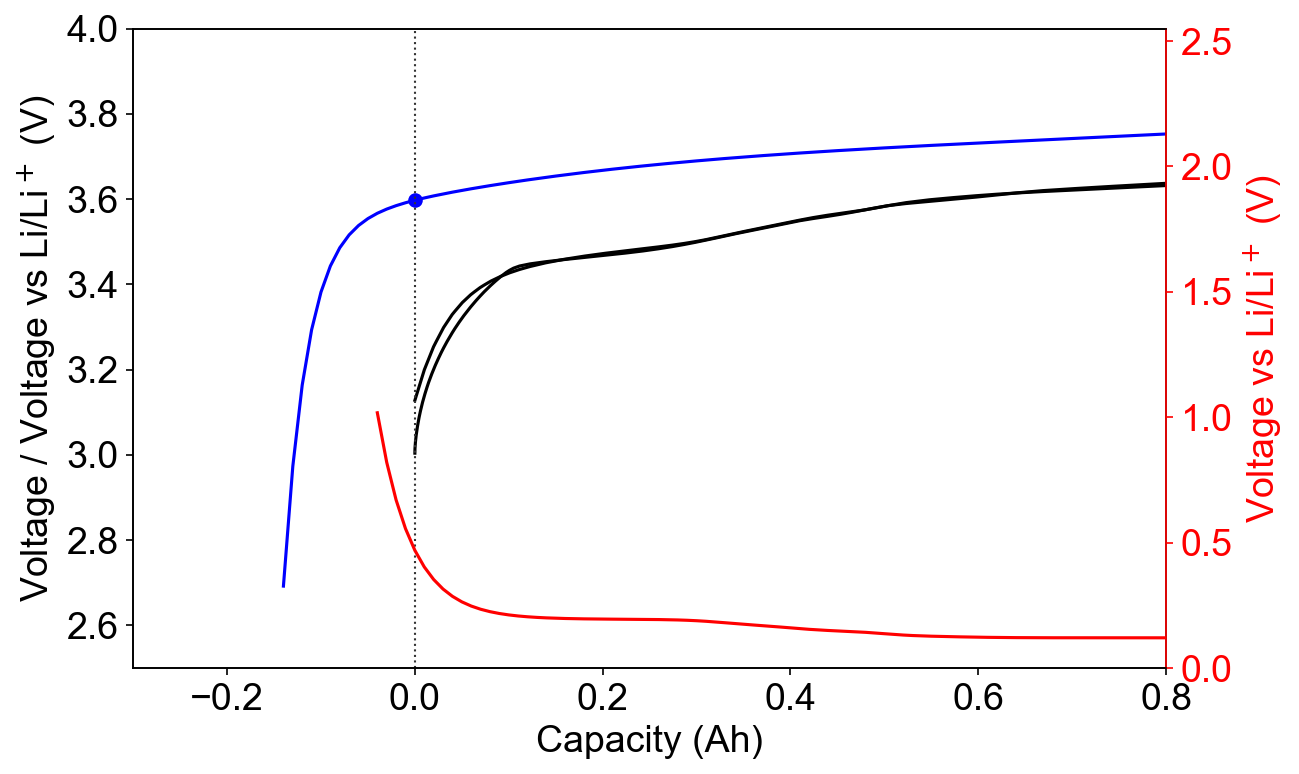

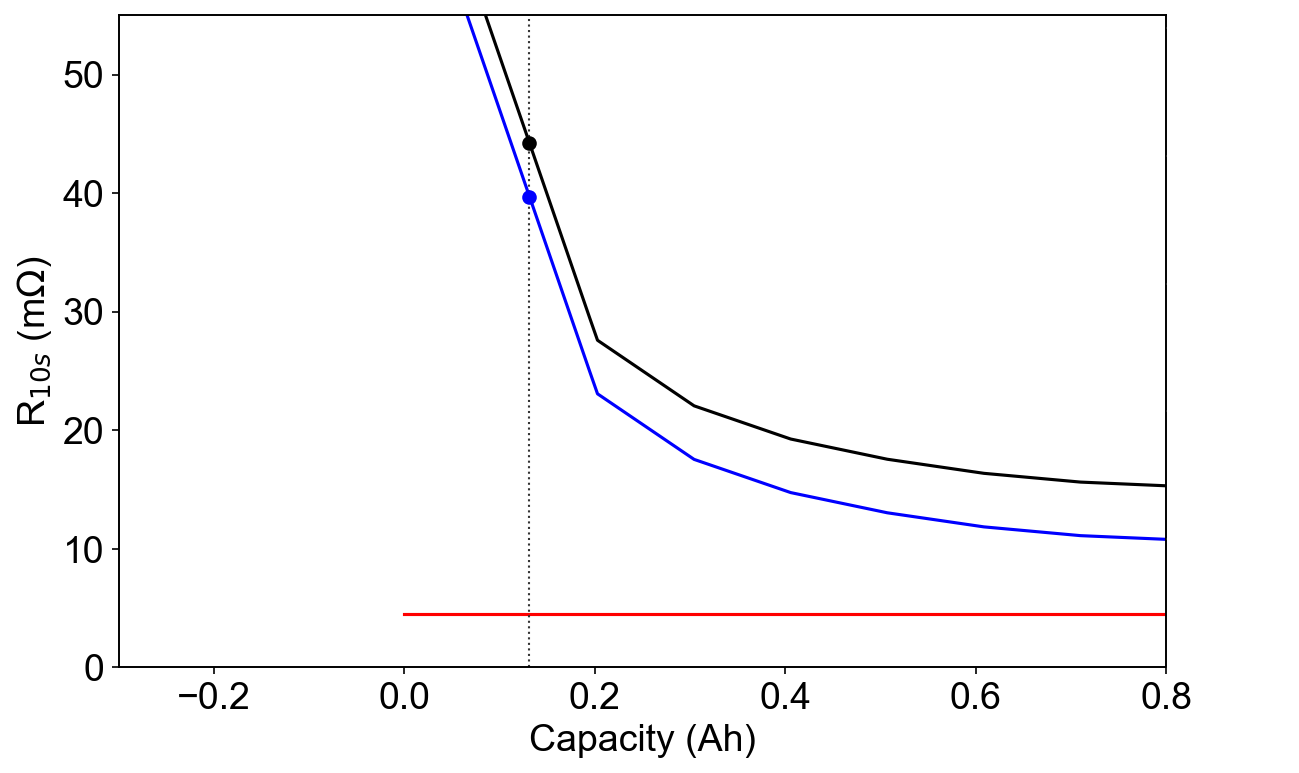

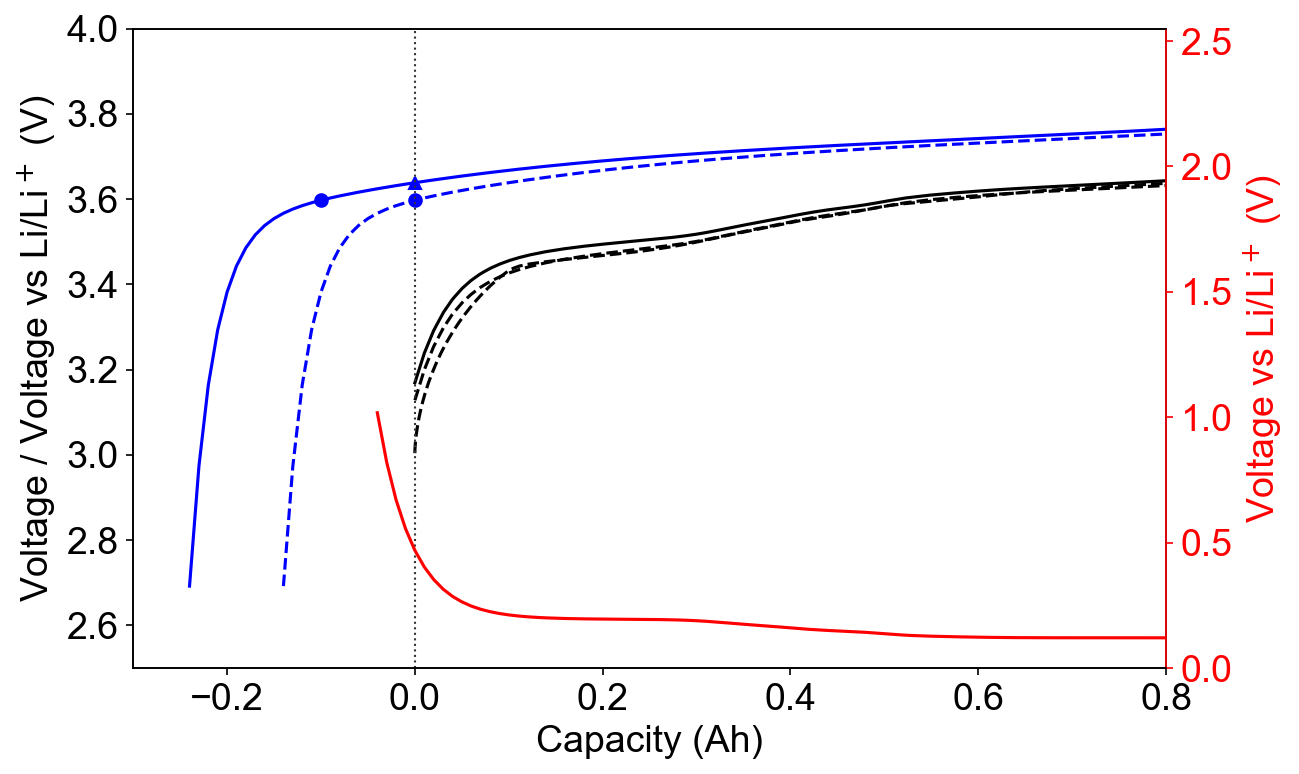

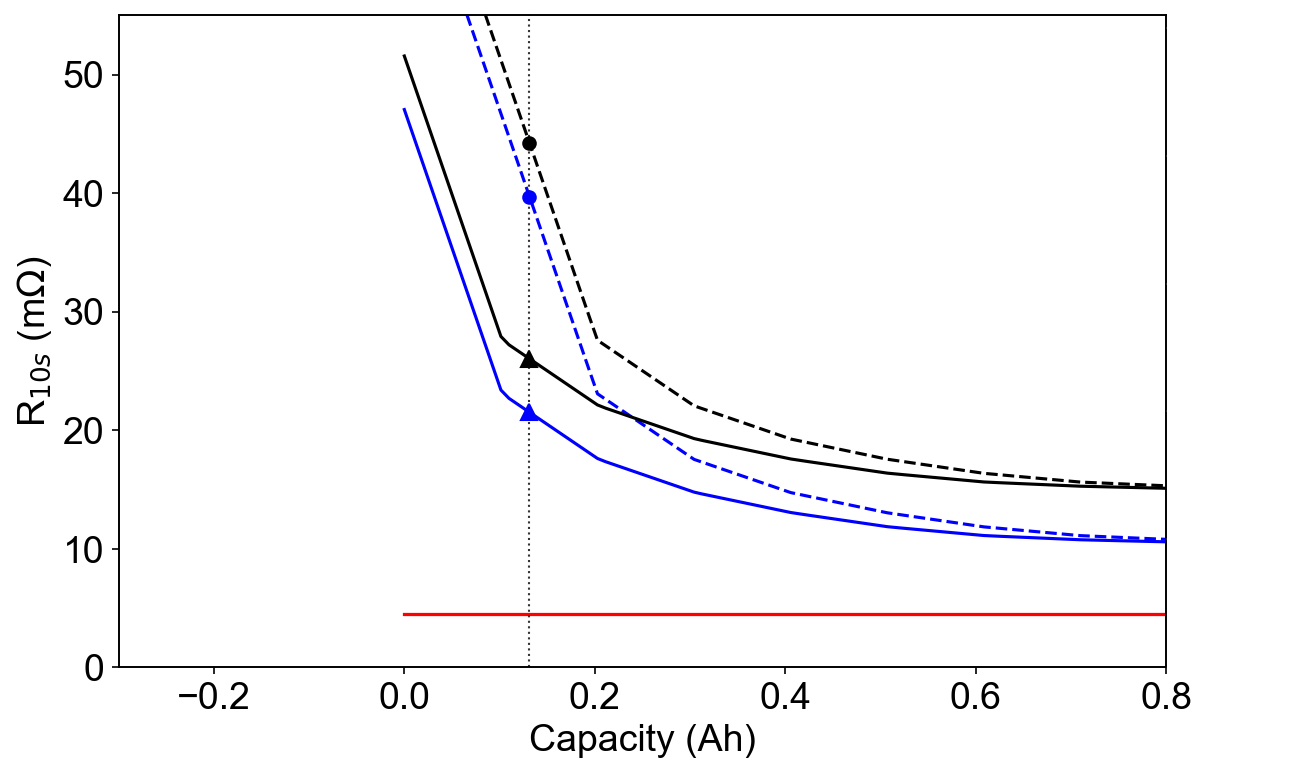

In [13]:
for include_fast in [False, True]:
    
    ls_base = '--' if include_fast else '-'
    
    fig_arr, ax_arr, ax2_arr = [], [], []

    ## First plot

    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()

    fig_arr.append(fig)

    ax.plot(q_pos, v_pos, color=COLOR_POS, linestyle=ls_base)
    ax2.plot(q_neg, v_neg, color=COLOR_NEG)

    ax.plot(q_full, v_full, color=COLOR_FULL, linestyle=ls_base)

    # Re-construct the full cell curve from the pos and neg electrodes
    q_shared = q_full
    fn_interp = interpolate.interp1d(q_pos, v_pos)
    v_pos_shared = fn_interp(q_shared)
    fn_interp = interpolate.interp1d(q_neg, v_neg)
    v_neg_shared = fn_interp(q_shared)
    v_full_reconst = v_pos_shared - v_neg_shared
    
    ax.plot(q_full, v_full_reconst, color=COLOR_FULL, linestyle=ls_base)

    if include_fast:
        # The shifted cathode curve
        ax.plot(q_pos - capacity_shift_ah, v_pos, color=COLOR_POS)
        
        # Re-construct the full cell curve from the new pos and neg electrodes
        q_shared = q_full
        fn_interp = interpolate.interp1d(q_pos - capacity_shift_ah, v_pos)
        v_pos_shared = fn_interp(q_shared)
        
        fn_interp = interpolate.interp1d(q_neg, v_neg)
        v_neg_shared = fn_interp(q_shared)
        
        v_full_reconst_shifted = v_pos_shared - v_neg_shared
        
        # Construct new full cell curve
        ax.plot(q_full, v_full_reconst_shifted, color=COLOR_FULL)

    # Put markers on the cathode curve at 0% SOC
    if include_fast:
        
        fn = interpolate.interp1d(q_pos, v_pos)
        ax.plot(0, fn(0), marker='o', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
       
        ax.plot(0 - capacity_shift_ah, fn(0), marker='o', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
        
        fn = interpolate.interp1d(q_pos - capacity_shift_ah, v_pos)

        ax.plot(0, fn(0), marker='^', markersize=6, 
                color=COLOR_POS, linestyle=ls_base)
        
    else:
        
        fn = interpolate.interp1d(q_pos, v_pos)
        v_pos_at_0_soc = fn(0)
        ax.plot(0, v_pos_at_0_soc, 
                marker='o', color=COLOR_POS, markersize=6)

        

    # Vertical line at 5% SOC
    ax.plot([0] * 2, [2.5, 4.5], color=COLOR_BG, linestyle=':', linewidth=1)

    ax.set_xlabel('Capacity (Ah)')
    ax.set_ylabel('Voltage / Voltage vs Li/Li$^+$ (V)')
    ax.set_xlim((-0.3, 0.8))
    ax.set_ylim((2.5, 4.0))

    ax2.tick_params(axis='y', colors=COLOR_NEG)
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))

    
    
    ## Second plot   
    fig, ax = plt.subplots(figsize=figsize)
    fig_arr.append(fig)

    ax.plot(base['capacity_expanded'], base['resistance_full_modeled'] * 1000,
            color=COLOR_FULL, linestyle=ls_base)

    ax.plot(base['capacity_expanded'], base['resistance_other'] * 1000,
             color=COLOR_NEG)

    ax.plot(base['capacity_expanded'], base['resistance_cathode'] * 1000,
            color=COLOR_POS, linestyle=ls_base)
    
    if include_fast:

        ax.plot(fast['capacity_expanded'], fast['resistance_other'] * 1000,
                 color=COLOR_NEG)

        ax.plot(fast['capacity_expanded'], fast['resistance_full_modeled'] * 1000, 
                color=COLOR_FULL)

        ax.plot(fast['capacity_expanded'], fast['resistance_cathode'] * 1000,
                color=COLOR_POS)

    # Vertical line at 5% SOC
    ax.plot([capacity_at_5_soc] * 2, [0, 55], color=COLOR_BG, linestyle=':', linewidth=1)

    # Put markers on the cathode and full cell resistance curves at 5% SOC
    fn = interpolate.interp1d(base['capacity_expanded'], base['resistance_full_modeled'])
    r_pos_at_5_soc = fn(capacity_at_5_soc)
    ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='o', color=COLOR_FULL, markersize=6)

    fn = interpolate.interp1d(base['capacity_expanded'], base['resistance_cathode'])
    r_pos_at_5_soc = fn(capacity_at_5_soc)
    ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='o', color=COLOR_POS, markersize=6)

    if include_fast: 

        fn = interpolate.interp1d(fast['capacity_expanded'], fast['resistance_full_modeled'])
        r_pos_at_5_soc = fn(capacity_at_5_soc)
        ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='^', color=COLOR_FULL, markersize=8)

        fn = interpolate.interp1d(fast['capacity_expanded'], fast['resistance_cathode'])
        r_pos_at_5_soc = fn(capacity_at_5_soc)
        ax.plot(capacity_at_5_soc, r_pos_at_5_soc * 1000, marker='^', color=COLOR_POS, markersize=8)

    ax.set_xlabel('Capacity (Ah)')
    ax.set_ylabel('R$_{10s}$ (m$\Omega$)')
    ax.set_xlim((-0.3, 0.8))
    ax.set_ylim(bottom=0, top=55)
    

    # Dummy secondary y-axis to get figsize to line up
    ax2 = ax.twinx()
    ax2.plot([], [], color='w')
    ax2.tick_params(axis='y', colors='w')
    ax2.yaxis.label.set_color('w')
    ax2.spines["right"].set_edgecolor('w')
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')


# Do a sensitivity study
2021/08/13

In [14]:
def fetch_voltage_resistance_dataset(df_esoh, df_hppc, 
                                     resistance_interp_kind='cubic', # cubic, linear
                                     resistance_curves_type='default',
                                     frac_cathode_resistance=0.7):
    """
    Load the raw data and package it in a neat way.
    
    Make the entire dataset share a common x-axis basis.
    
    Parameters
    ----------
        df_esoh (DataFrame)
            DataFrame containing the eSOH data
        ef_hppc (DataFrame)
            DataFrame containing the HPPC data
        resistance_interp_kind
          the resistance measured by HPPC is discretized.
          this option lets the user set what kindof interpolation to do
          suggested options:
            linear: least "data creation"
            cubic: smooth curves for demonstration
        resistance_curves_type (str):
            default: cathode dominated
            swapped: anode dominated
            split: 50/50 partitioning
          
    Outputs a dictionary containing:
        capacity (Ah) : shared capacity basis
        positive electrode voltage (V)
        positive electrode resistance (mOhms)
        negative electrode voltage (V)
        negative electrode resistance (mOhms)
    """
    
    # Declare shared capacity basis
    shared_q = np.arange(-0.5, 3.01, 0.001)

    ## Unpack the equilibrium voltage data
    
    # Source: eSOH fitting outputs
    pos_q = df_esoh['pos']['Q']
    pos_v = df_esoh['pos']['V']
    neg_q = df_esoh['neg']['Q']
    neg_v = df_esoh['neg']['V']

    # Make data share common x-grid
    fn = interpolate.interp1d(pos_q, pos_v, bounds_error=False)
    pos_v = fn(shared_q)

    fn = interpolate.interp1d(neg_q, neg_v, bounds_error=False)
    neg_v = fn(shared_q)
    
    # Bring full cell voltage 3.0V back to "origin"
    # This must be done because the equilibrium voltage data doesn't
    # Precisely match the full cell voltage, leading to some voltage error
    # This error is quite large at low voltages where the shape of the 
    # Thermodynamic is large. This creates a misalignment in what the eSOH
    # Model thinks is 0% SOC and what the data actually is saying
    ful_v  = pos_v - neg_v
    fn = interpolate.interp1d(ful_v, shared_q)
    model_error_cap_offset = fn(3.0)
    shared_q = shared_q - model_error_cap_offset

    ## Unpack the resistance data 
    
    # Source: HPPC pulse data

    # Collect the full cell data    
    capacity = df_hppc['capacity']

    # Build a higher fidelity, smooth signal for the toy model
    resistance = df_hppc['resistance_10s_ohm']
    capacity_hifi = np.linspace(np.min(capacity), np.max(capacity), 300)
    interp_fn = interpolate.interp1d(capacity, resistance, 
                                     bounds_error=False, 
                                     kind=resistance_interp_kind)
    resistance_hifi = interp_fn(capacity_hifi)

    # Build the synthetic curves from the toy model
    
    if resistance_curves_type == 'default':
        
        res_dict = compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                         frac_cathode_resistance)
    
    elif resistance_curves_type == 'swapped':
          
        res_dict = compute_resistance_curves(capacity_hifi, resistance_hifi, 
                                         frac_cathode_resistance, 
                                         swap_cathode_anode=True)
        
    elif resistance_curves_type == 'split':
        
        res_dict = compute_resistance_curves(capacity_hifi, resistance_hifi,
                                         frac_cathode_resistance, 
                                         split_proportionally=True)   
        
    else:
        
        assert f'"{resistance_curves_type}" is not a valid argument'


    res_q = res_dict['capacity_expanded']
    pos_r = res_dict['resistance_cathode']
    neg_r = res_dict['resistance_other']

    # Make data share common x-grid
    fn = interpolate.interp1d(res_q, pos_r, bounds_error=False, fill_value=np.NaN)
    pos_r_shared = fn(shared_q)

    fn = interpolate.interp1d(res_q, neg_r, bounds_error=False, fill_value=np.NaN)
    neg_r_shared = fn(shared_q)
    
    # Trim cathode voltage model output to end at 3V
    # (Don't let it extrapolate too much)
    pos_v[np.where(pos_v < 3.0)] = np.NaN
    
    # Package the results
    out = dict()
    out['capacity'] = shared_q
    out['pos_v'] = pos_v
    out['pos_r'] = pos_r_shared
    out['neg_v'] = neg_v
    out['neg_r'] = neg_r_shared
    
    return out

In [15]:
def voltage_resistance_transform(res, shift_ah, 
                                 pos_shrink_frac=0,
                                 pos_shrink_loc='bottom',
                                 neg_shrink_frac=0,
                                 neg_shrink_loc='bottom'):
    """
    Modify the voltage-resistance curves using a shift
    
    Parameters
    ---------
        res (Dict)
            contains the voltage and resistance curves
        shift_ah (numeric)
            value to shift by in Amp-hours
        pos_shrink_frac (numeric, 0-1)
            percentage to shrink the positive electrode curve
        pos_shrink_loc (str)
            shrink from either 'top' or 'bottom'
        neg_shrink_frac (numeric, 0-1)
            percentage to shrink the negative electrode curve
        neg_shrink_loc (str)
            shrink from either 'top' or 'bottom'
        
    Outputs
    ---------
         res_out (Dict)
             modified contents after the shift takes place
         some other useful metrics

    """
        
    assert pos_shrink_frac < 1 and pos_shrink_frac >=0, \
        'Positive electrode shrinkage must be a fraction.'
    assert neg_shrink_frac < 1 and neg_shrink_frac >=0, \
        'Negative electrode shrinkage must be a fraction.'
    
    res_out = res.copy()
    
    ## Perform the shift 
    
    fn = interpolate.interp1d(res['capacity'] + shift_ah, 
                              res['pos_v'], bounds_error=False)
    res_out['pos_v'] = fn(res['capacity'])

    fn = interpolate.interp1d(res['capacity'] + shift_ah, 
                              res['pos_r'], bounds_error=False)
    res_out['pos_r'] = fn(res['capacity'])
    
    # Shrink the positive curve
    orig_capacity = res_out['capacity'].copy()
    pos_voltage = res_out['pos_v'].copy()
    pos_resistance = res_out['pos_r'].copy()
    pos_capacity = res_out['capacity'].copy()

    if pos_shrink_loc == 'top':
        pivot_index = np.where(~np.isnan(pos_voltage))[0][0]
    elif pos_shrink_loc == 'bottom':
        pivot_index = np.where(~np.isnan(pos_voltage))[0][-1]
    else:
        assert "Shrink location must be either 'top' or 'bottom'"

    temp_offset = pos_capacity[pivot_index]

    pos_capacity -= temp_offset 
    pos_capacity = pos_capacity * (1 - pos_shrink_frac)
    pos_capacity += temp_offset 
    
    fn = interpolate.interp1d(pos_capacity, pos_voltage, bounds_error=False)
    res_out['pos_v'] = fn(orig_capacity)
    
    fn = interpolate.interp1d(pos_capacity, pos_resistance, bounds_error=False)
    res_out['pos_r'] = fn(orig_capacity)

    # Shrink the negative curve
    orig_capacity = res_out['capacity'].copy()
    neg_voltage = res_out['neg_v'].copy()
    neg_resistance = res_out['neg_r'].copy()
    neg_capacity = res_out['capacity'].copy()

    if neg_shrink_loc == 'top':
        pivot_index = np.where(~np.isnan(neg_voltage))[0][0]
    elif neg_shrink_loc == 'bottom':
        pivot_index = np.where(~np.isnan(neg_voltage))[0][-1]
    else:
        assert "Shrink location must be either 'top' or 'bottom'"

    temp_offset = neg_capacity[pivot_index]

    neg_capacity -= temp_offset 
    neg_capacity = neg_capacity * (1 - neg_shrink_frac)
    neg_capacity += temp_offset 
    
    fn = interpolate.interp1d(neg_capacity, neg_voltage, bounds_error=False)
    res_out['neg_v'] = fn(orig_capacity)
    
    fn = interpolate.interp1d(neg_capacity, neg_resistance, bounds_error=False)
    res_out['neg_r'] = fn(orig_capacity)
    
    return res_out



In [16]:
def compute_useful_metrics(res, soc_target=0.05):
    """
    Take a standard result set and parse out some useful metrics
    
    Parameters
    ---------
        res (Dict)
            contains the voltage and resistance curves
        soc_target (0-1)
            target SOC for extracting the metrics
    
    Outputs (dictionary)
    ---------
        absolute capacity (Ah) : arbitrary x basis
        resistance at target SOC (mOhms)
        cell capacity (Ah) : respects voltage limits
        x0 : anode stoichiometry at SOC target
        y0 : anode stoichiometry at SOC target
        pos_v_at_100_soc: positive electrode voltage at 100% SOC
    """
    
    ful_v = res['pos_v'] - res['neg_v']
    ful_r = res['pos_r'] + res['neg_r']

    # Re-compute the cell capacity based on the voltage window renormalization
    fn = interpolate.interp1d(ful_v, res['capacity'])
    max_cap = fn(MAX_VOLTAGE)
    min_cap = fn(MIN_VOLTAGE)
    cell_cap = max_cap - min_cap

    # The capacity basis is a tricky thing. As the positive and negative curves slide
    # Around, the point at which the full cell equals Min Voltage (e.g. 3.0V) will change
    # On the basis of the full cell, 3.0V defines 0% SOC. So let's be careful about where
    # we take "5%" SOC
    absolute_cap_at_target_soc = min_cap + soc_target * cell_cap

    fn = interpolate.interp1d(res['capacity'], ful_r)

    resistance_at_target_soc = fn(absolute_cap_at_target_soc)
    
    # Compute x and y at target SOC
    idx0 = np.where(~np.isnan(res['pos_v']))[0][0]
    idx1 = np.where(~np.isnan(res['pos_v']))[0][-1]
    cathode_capacity = res['capacity'][idx1] - res['capacity'][idx0]
    cathode_capacity_at_target_soc = absolute_cap_at_target_soc - res['capacity'][idx0]
    y0 = 1 - cathode_capacity_at_target_soc / cathode_capacity
    
    idx0 = np.where(~np.isnan(res['neg_v']))[0][0]
    idx1 = np.where(~np.isnan(res['neg_v']))[0][-1]
    anode_capacity = res['capacity'][idx1] - res['capacity'][idx0]    
    anode_capacity_at_target_soc = absolute_cap_at_target_soc - res['capacity'][idx0]
    x0 = anode_capacity_at_target_soc / anode_capacity
    
    # Cathode potential at Max Voltage
    fn = interpolate.interp1d(res['capacity'], res['pos_v'])
    pos_v_at_100_soc = fn(max_cap) 
    
    # Package outputs
    output_dict = dict()
    output_dict['absolute_cap_at_target_soc'] = absolute_cap_at_target_soc
    output_dict['resistance_at_target_soc'] = resistance_at_target_soc
    output_dict['cell_cap'] = cell_cap
    output_dict['x0'] = x0
    output_dict['y0'] = y0
    output_dict['pos_v_at_100_soc'] = pos_v_at_100_soc
    
    return output_dict

# The zoomed in plot for concept illustration

In [17]:
target_soc = 0.05

res_orig = fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3, 
                                            frac_cathode_resistance=0.70,
                                            resistance_curves_type='default') # default, split, swapped

metrics_orig = compute_useful_metrics(res_orig, target_soc)   

XLIM = (-0.25, 0.8)
# XLIM = (-0.3, 3.0)

def plot_shift(shift_mah, pos_shrink, neg_shrink):

    res = voltage_resistance_transform(res_orig, shift_mah / 1000,
                                       pos_shrink_loc='bottom',
                                       neg_shrink_loc='top',
                                       pos_shrink_frac=pos_shrink,
                                       neg_shrink_frac=neg_shrink)
    

    metrics = compute_useful_metrics(res, target_soc)   
    
    plt.figure(figsize=(8, 10))

    # Make the voltage plots
    plt.subplot(2,1,1)

    fig_arr.append(fig)
    
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()

    ax1.axvline(x=metrics['absolute_cap_at_target_soc'], color=COLOR_REF)
    ax1.axvline(x=metrics_orig['absolute_cap_at_target_soc'], color=COLOR_REF, linestyle=':', linewidth=0.7)

    ax1.plot(res['capacity'], res['pos_v'], color=COLOR_POS)
    ax2.plot(res['capacity'], res['neg_v'], color=COLOR_NEG)
    ax1.plot(res_orig['capacity'], res_orig['pos_v'], color=COLOR_POS, linestyle=':', linewidth=0.7)
    ax2.plot(res_orig['capacity'], res_orig['neg_v'], color=COLOR_NEG, linestyle=':', linewidth=0.7)

    ax1.plot(res['capacity'], res['pos_v'] - res['neg_v'], 
             color=COLOR_FULL)
    ax1.plot(res_orig['capacity'], res_orig['pos_v'] - res_orig['neg_v'], 
             color=COLOR_FULL, linestyle=':', linewidth=0.7)

    ax1.set_xlabel('Capacity (Ah)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlim(XLIM)
    ax1.set_ylim((2.6, 4.0))
    
    ax2.tick_params(axis='y', colors=COLOR_NEG)
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))

    # Make the resistance plot
    plt.subplot(2,1,2)
    plt.axvline(x=metrics['absolute_cap_at_target_soc'], color=COLOR_REF)
    plt.axvline(x=metrics_orig['absolute_cap_at_target_soc'], color=COLOR_REF, linestyle=':', linewidth=0.7)

    plt.plot(res['capacity'], res['pos_r'] * 1000, color=COLOR_POS)
    plt.plot(res_orig['capacity'], res_orig['pos_r'] * 1000, color=COLOR_POS, linestyle=':', linewidth=0.7)
    plt.plot(res['capacity'], res['neg_r'] * 1000, color=COLOR_NEG)
    plt.plot(res_orig['capacity'], res_orig['neg_r'] * 1000, color=COLOR_NEG, linestyle=':', linewidth=0.7)
    plt.plot(res['capacity'], (res['pos_r'] + res['neg_r']) * 1000, color=COLOR_FULL)
    plt.plot(res_orig['capacity'], (res_orig['pos_r'] + res_orig['neg_r']) * 1000, color=COLOR_FULL, linestyle=':', linewidth=0.7)

    # Put dots for the 5% SOC points
    plt.plot(metrics_orig['absolute_cap_at_target_soc'], 
             metrics_orig['resistance_at_target_soc'] * 1000, marker='o', color=[0.5, 0.5, 0.5])
    plt.plot(metrics['absolute_cap_at_target_soc'], 
             metrics['resistance_at_target_soc'] * 1000, marker='o', color='black')
    
    plt.xlabel('Capacity (Ah)')
    plt.ylabel('R$_{10s}$ (m$\Omega$)')

    plt.xlim(XLIM)
    plt.ylim((0, 55))
    plt.tight_layout()
    
    
interact(plot_shift, shift_mah=widgets.FloatSlider(min=-200, max=100, step=10),
                     pos_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     neg_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005))

interactive(children=(FloatSlider(value=0.0, description='shift_mah', min=-200.0, step=10.0), FloatSlider(valu…

<function __main__.plot_shift(shift_mah, pos_shrink, neg_shrink)>

# The smaller plots for inserting into a pane

In [18]:
target_soc = 0.05

res_orig = fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3, 
                                            frac_cathode_resistance=0.70,
                                            resistance_curves_type='default') # default, split, swapped

metrics_orig = compute_useful_metrics(res_orig, target_soc)   

XLIM = (-0.25, 0.8)
# XLIM = (-0.3, 3.0)

def plot_shift(shift_mah, pos_shrink, neg_shrink):

    res = voltage_resistance_transform(res_orig, shift_mah / 1000,
                                       pos_shrink_loc='bottom',
                                       neg_shrink_loc='top',
                                       pos_shrink_frac=pos_shrink,
                                       neg_shrink_frac=neg_shrink)
    

    metrics = compute_useful_metrics(res, target_soc)   
    
    plt.figure(figsize=(8, 6))

    # Make the voltage plots
    plt.subplot(2,1,1)

    fig_arr.append(fig)
    
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()

    ax1.axvline(x=metrics['absolute_cap_at_target_soc'], color=COLOR_REF)
    ax1.axvline(x=metrics_orig['absolute_cap_at_target_soc'], color=COLOR_REF, linestyle=':', linewidth=0.7)

    ax1.plot(res['capacity'], res['pos_v'], color=COLOR_POS)
    ax2.plot(res['capacity'], res['neg_v'], color=COLOR_NEG)
    ax1.plot(res_orig['capacity'], res_orig['pos_v'], color=COLOR_POS, linestyle=':', linewidth=0.7)
    ax2.plot(res_orig['capacity'], res_orig['neg_v'], color=COLOR_NEG, linestyle=':', linewidth=0.7)

    ax1.plot(res['capacity'], res['pos_v'] - res['neg_v'], 
             color=COLOR_FULL)
    ax1.plot(res_orig['capacity'], res_orig['pos_v'] - res_orig['neg_v'], 
             color=COLOR_FULL, linestyle=':', linewidth=0.7)

#     ax1.set_xlabel('Capacity (Ah)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlim(XLIM)
    ax1.set_ylim((2.6, 4.6))
    
    ax1.set_xticklabels([])

    
    ax2.tick_params(axis='y', colors=COLOR_NEG)
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.set_ylabel('Voltage vs Li/Li$^+$ (V)')
    ax2.set_ylim((0, 2.55))
    
#     metrics2 = compute_useful_metrics(res, target_soc - 0.00278)   
#     plt.axvline(x=metrics2['absolute_cap_at_target_soc'], color=COLOR_REF)

#     plt.axvline(x=0, color=COLOR_REF)
#     plt.axvline(x=0 - 0.00278, color=COLOR_REF)

#     plt.legend([f'$\Delta$ Q$_\mathrm{{LLI}}$ = {shift_mah} mAh \n $x_{{100}}$ = {x0:.4f} \n $y_100$ = {y0:.4f} \n V$_\mathrm{{pos, 100\%SOC}}$ = {pos_v_at_100_soc :.3f} V'], 
#                handlelength=0, frameon=False)
#     plt.title(f"""
#                 $\Delta$ Q$_\mathrm{{LLI}}$ = {shift_mah} mAh 
#                 $x_{{100}}$ = {metrics['x0']:.4f}
#                 $y_{{100}}$ = {metrics['y0']:.4f} 
#                 V$_\mathrm{{pos, 100\%SOC}}$ = {metrics['pos_v_at_100_soc'] :.3f} V
#                 """)
#     plt.title(f"$\Delta$ Q$_\mathrm{{LLI}}$ = {shift_mah} mAh \n V$_\mathrm{{pos, 100\%SOC}}$ = {metrics['pos_v_at_100_soc'] : .4f} V vs. Li/Li$^+$")

#     plt.legend([f'V$_\mathrm{{pos, 100\%SOC}}$: {metrics['pos_v_at_100_soc'] :.3f} V'], 
#                handlelength=0, frameon=False)

    
#     plt.xlim((-0.01, 0.01))
#     plt.ylim((0.30, 0.34))

    # Make the resistance plot
    plt.subplot(2,1,2)
    plt.axvline(x=metrics['absolute_cap_at_target_soc'], color=COLOR_REF)
    plt.axvline(x=metrics_orig['absolute_cap_at_target_soc'], color=COLOR_REF, linestyle=':', linewidth=0.7)

    plt.plot(res['capacity'], res['pos_r'] * 1000, color=COLOR_POS)
    plt.plot(res_orig['capacity'], res_orig['pos_r'] * 1000, color=COLOR_POS, linestyle=':', linewidth=0.7)
    plt.plot(res['capacity'], res['neg_r'] * 1000, color=COLOR_NEG)
    plt.plot(res_orig['capacity'], res_orig['neg_r'] * 1000, color=COLOR_NEG, linestyle=':', linewidth=0.7)
    plt.plot(res['capacity'], (res['pos_r'] + res['neg_r']) * 1000, color=COLOR_FULL)
    plt.plot(res_orig['capacity'], (res_orig['pos_r'] + res_orig['neg_r']) * 1000, color=COLOR_FULL, linestyle=':', linewidth=0.7)

    # Put dots for the 5% SOC points
    plt.plot(metrics_orig['absolute_cap_at_target_soc'], 
             metrics_orig['resistance_at_target_soc'] * 1000, marker='o', color=[0.5, 0.5, 0.5])
    plt.plot(metrics['absolute_cap_at_target_soc'], 
             metrics['resistance_at_target_soc'] * 1000, marker='o', color='black')
    
    plt.xlabel('Capacity (Ah)')
    plt.ylabel('R$_{10s}$ (m$\Omega$)')
#     plt.legend([f'R$_{{10s,{target_soc*100}\%SOC}}$ = {resistance_at_target_soc * 1000 :.1f} m$\Omega$'], 
#                handlelength=0, frameon=False)

    plt.xlim(XLIM)
    plt.ylim((0, 55))
    plt.tight_layout()
    
    
interact(plot_shift, shift_mah=widgets.FloatSlider(min=-200, max=100, step=10),
                     pos_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005),
                     neg_shrink=widgets.FloatSlider(min=0, max=0.2, step=0.005))

interactive(children=(FloatSlider(value=0.0, description='shift_mah', min=-200.0, step=10.0), FloatSlider(valu…

<function __main__.plot_shift(shift_mah, pos_shrink, neg_shrink)>

## Visualize sensitivities

In [19]:
# Configure globals

res_orig = fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3,
                                           resistance_curves_type='default')
target_soc_vec = [0.02, 0.05, 0.07, 0.1]
colors = plt.cm.winter(np.linspace(0, 1, len(target_soc_vec)))
top_or_bottom_vec = ['top', 'bottom']

# Define noise constants (see 'signal_to_noise_analysis.ipynb')
#
# SOC = 2% : 2.615 mAh
# SOC = 5% : 4.067 mAh
# SOC = 7% : 7.321 mAh
# SOC = 10% : 36.604 mAh

# Error in Q_LLI estimation based on Qd
q_error_mah = 22.22

# Error in Q_LLI estimation based on RLS
# (depends on slopes)
# 2, 5, 7, 10%
rls_error_mah = [2.615, 4.067, 7.321, 36.604] 

## Lithium consumption

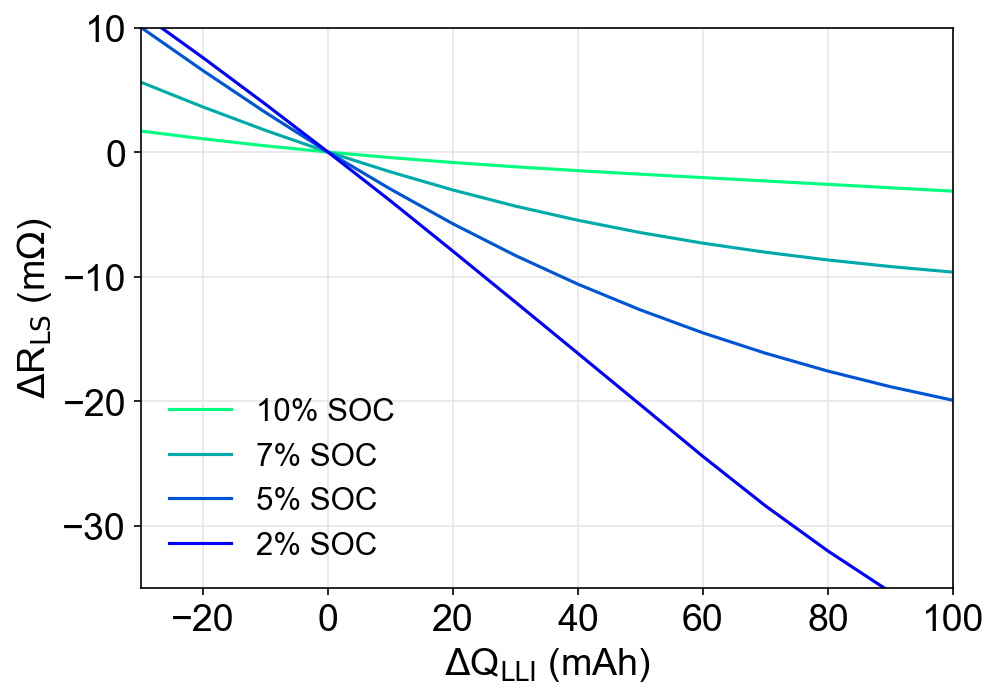

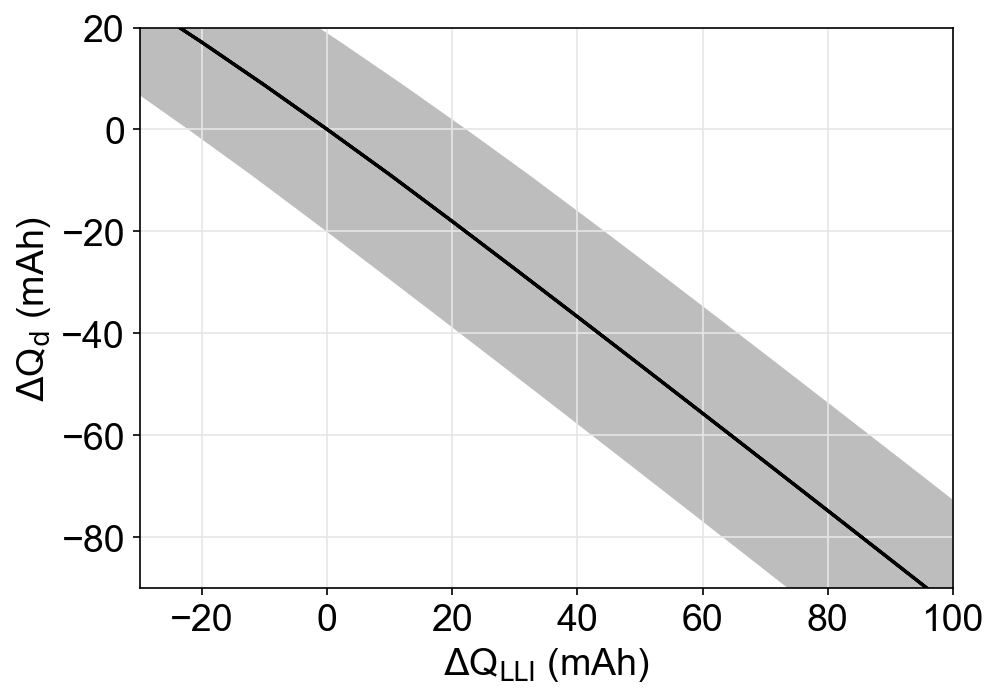

In [20]:
shift_ah_vec = np.arange(-0.1, 0.031, 0.01)

plt.figure()
ax1 = plt.gca()

plt.figure()
ax2 = plt.gca()

for i, target_soc in reversed(list(enumerate(target_soc_vec))):
    
    metrics_orig = compute_useful_metrics(res_orig, target_soc)

    res_target_soc_vec = []
    cell_cap_vec = []

    for shift_ah in shift_ah_vec:
    
        res = voltage_resistance_transform(res_orig, shift_ah)

        metrics = compute_useful_metrics(res, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    delta_qlli = -shift_ah_vec
    
    x = delta_qlli * 1000
    y = (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000
    
    ax1.plot(x, y,
             label=f'{target_soc * 100 :.0f}% SOC ',
             color=colors[i])
    
    # Plot noise in the RLS measuremet converted to QLLI estimation inaccuracy
#     ax1.fill_betweenx(y, x - rls_error_mah[i], x + rls_error_mah[i], color=colors[i], alpha=0.07, linewidth=0.0)
    ax1.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
    ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
    ax1.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
    ax1.set_ylim((-35, 10))
    ax1.grid(True, color=(0.9, 0.9, 0.9))

    
    # The capacity plot
    x = delta_qlli * 1000
    y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
    
    ax2.plot(x, y, color='k')
    
    # Plot noise in the Qd measurement converted into QLLI estimation inaccuracy
    ax2.fill_betweenx(y, x - q_error_mah, x + q_error_mah, 
                     color='k', alpha=0.07, linewidth=0.0)
    
    ax2.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
    ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
    
    ax2.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
    ax2.set_ylim((-90, 20))
    ax2.grid(True, color=(0.9, 0.9, 0.9))
    
ax1.legend(prop={'size': 15}, frameon=False)

## Positive active material losses

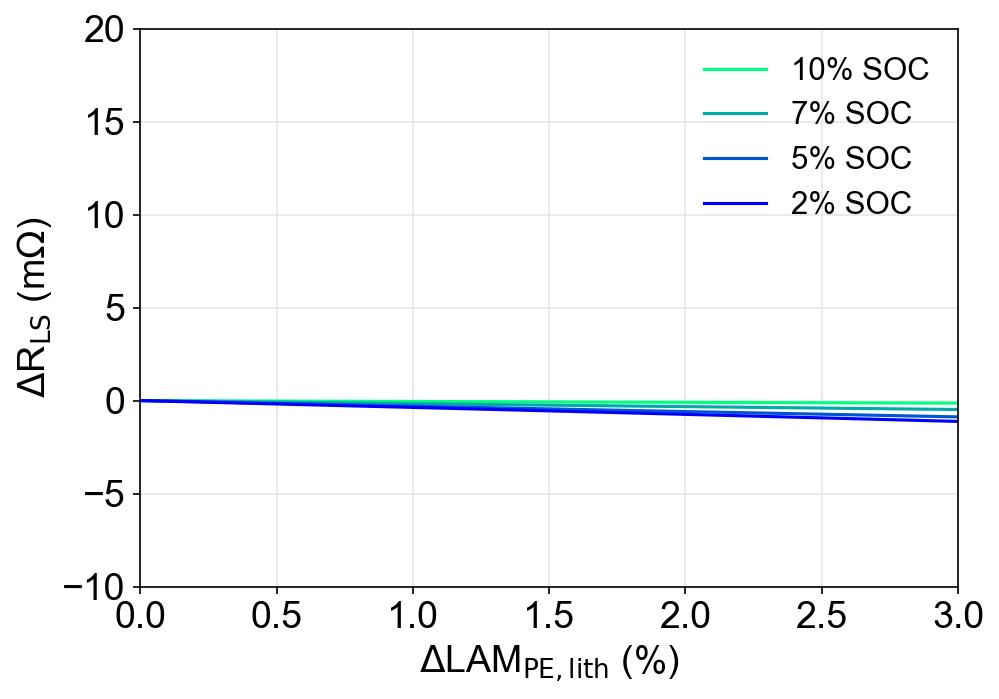

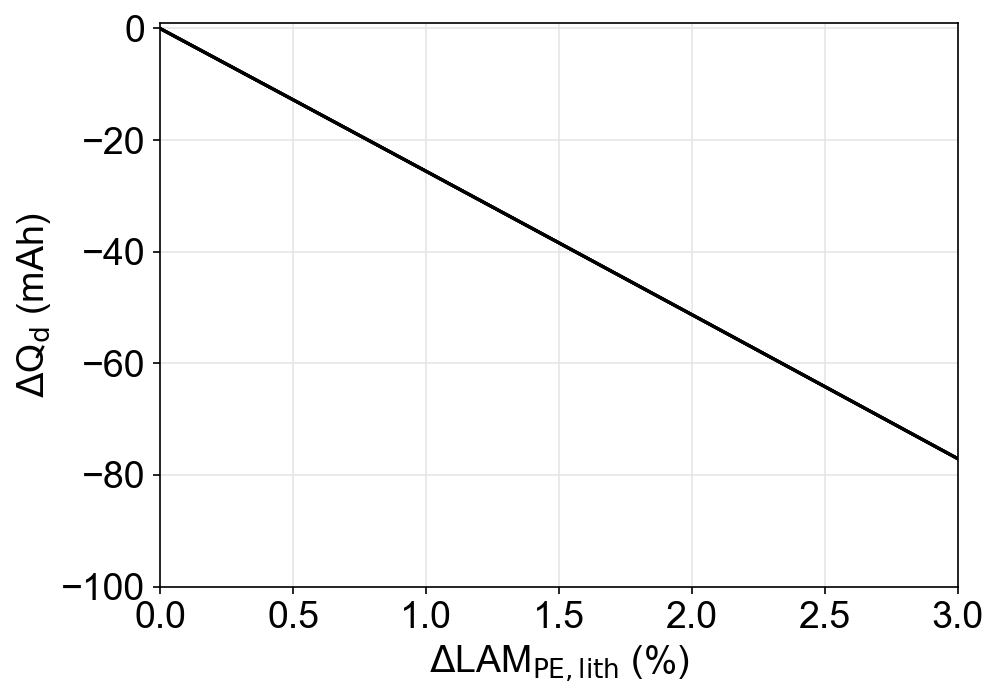

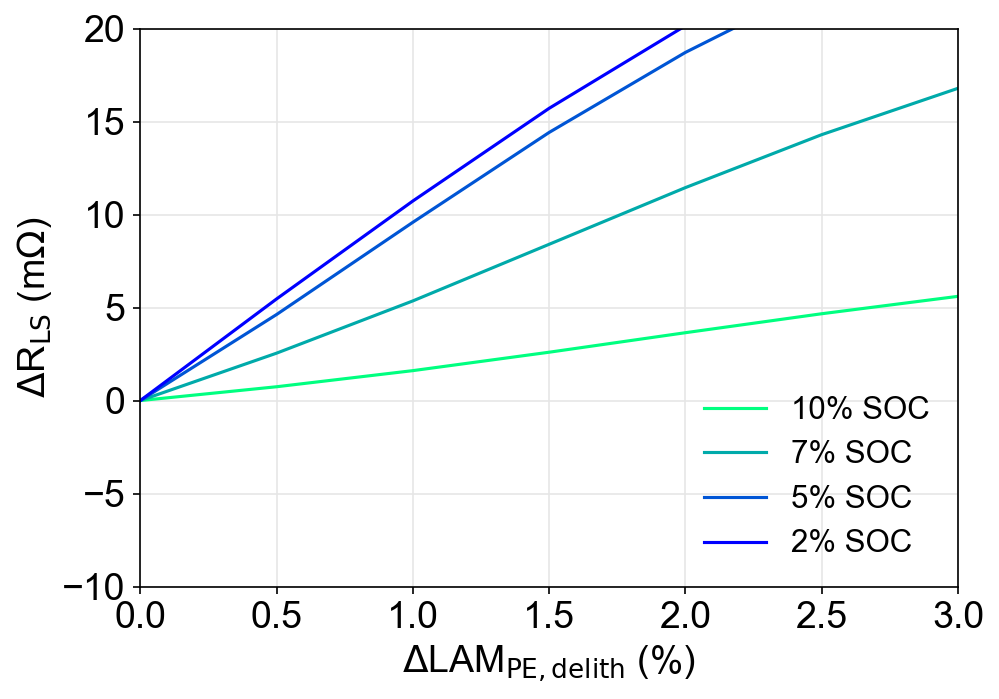

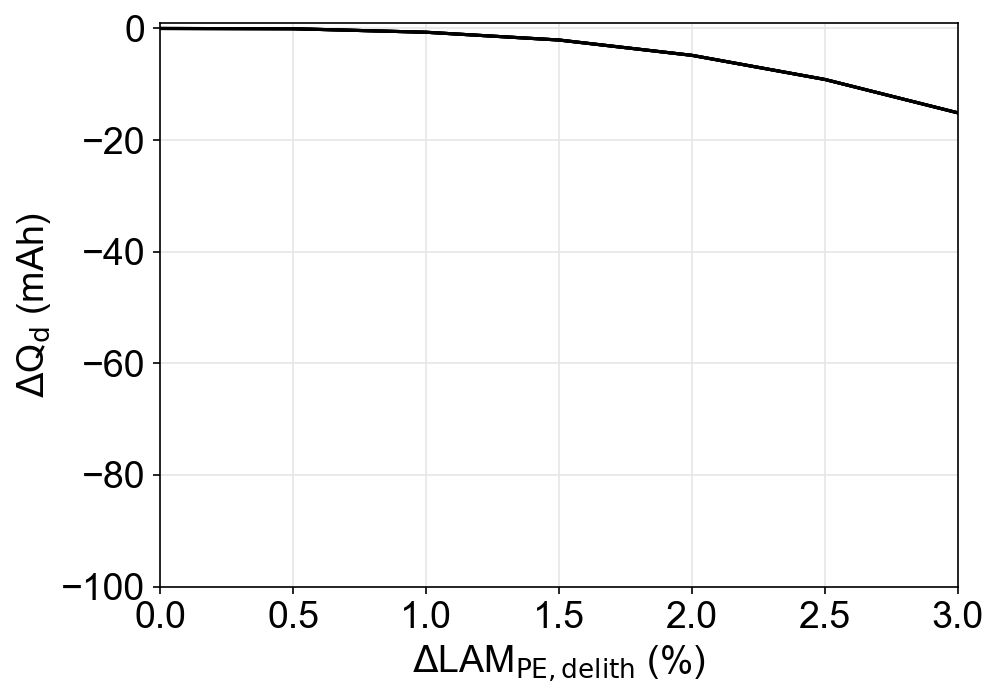

In [25]:
shift_ah = 0

pos_shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

top_or_bottom_vec = ['top', 'bottom']

for top_or_bottom in top_or_bottom_vec:
    
    top_bottom_str = 'delith' if top_or_bottom == 'bottom' else 'lith'

    plt.figure()
    ax1 = plt.gca()

    plt.figure()
    ax2 = plt.gca()

    for i, target_soc in reversed(list(enumerate(target_soc_vec))):

        metrics_orig = compute_useful_metrics(res_orig, target_soc)

        res_target_soc_vec = []
        cell_cap_vec = []

        for pos_shrink_frac in pos_shrink_frac_vec:

            res = voltage_resistance_transform(res_orig, shift_ah,
                                              pos_shrink_loc=top_or_bottom,
                                              pos_shrink_frac=pos_shrink_frac)

            metrics = compute_useful_metrics(res, target_soc)

            res_target_soc_vec.append(metrics['resistance_at_target_soc'])
            cell_cap_vec.append(metrics['cell_cap'])

        res_target_soc_vec = np.array(res_target_soc_vec)
        cell_cap_vec = np.array(cell_cap_vec)

        ax1.plot(pos_shrink_frac_vec * 100, (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
                label=f'{target_soc * 100 :.0f}% SOC',
                 color=colors[i])

        ax1.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{PE, {top_bottom_str}}}}}$ (%)')
        ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
        ax1.set_xlim(np.min(pos_shrink_frac_vec) * 100, np.max(pos_shrink_frac_vec) * 100)
        ax1.set_ylim((-10, 20))
        ax1.grid(True, color=(0.9, 0.9, 0.9))


        x = pos_shrink_frac_vec * 100
        y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
        
        ax2.plot(x, y, color='k')
        ax2.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{PE, {top_bottom_str}}}}}$ (%)')
        ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
        ax2.set_xlim(np.min(pos_shrink_frac_vec) * 100, np.max(pos_shrink_frac_vec) * 100)
        ax2.set_ylim((-100, 1))
        ax2.grid(True, color=(0.9, 0.9, 0.9))


    ax1.legend(prop={'size': 15}, frameon=False)

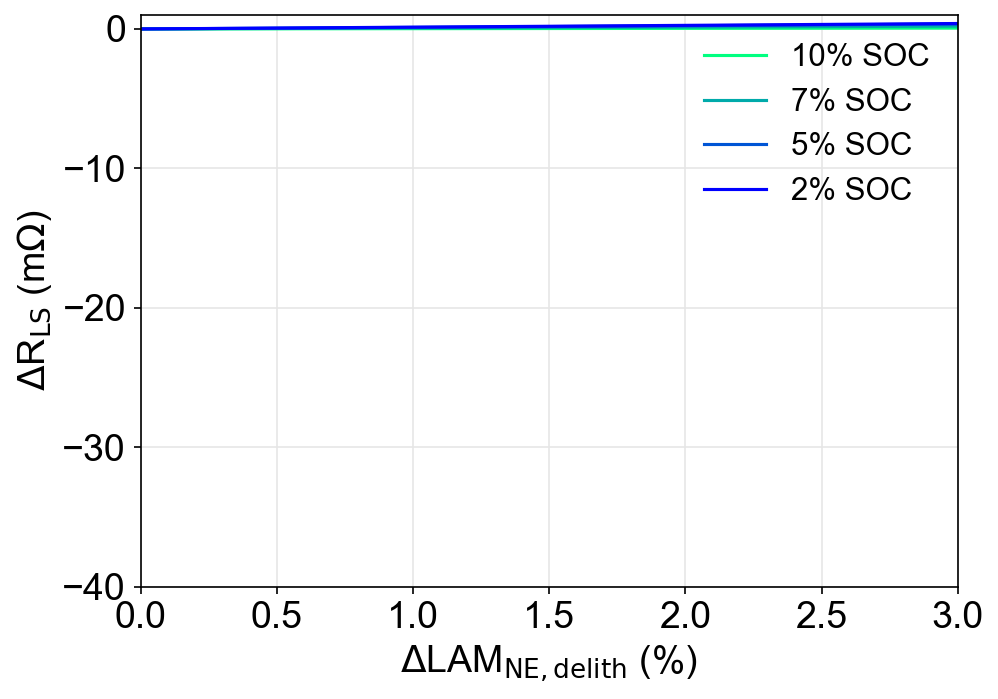

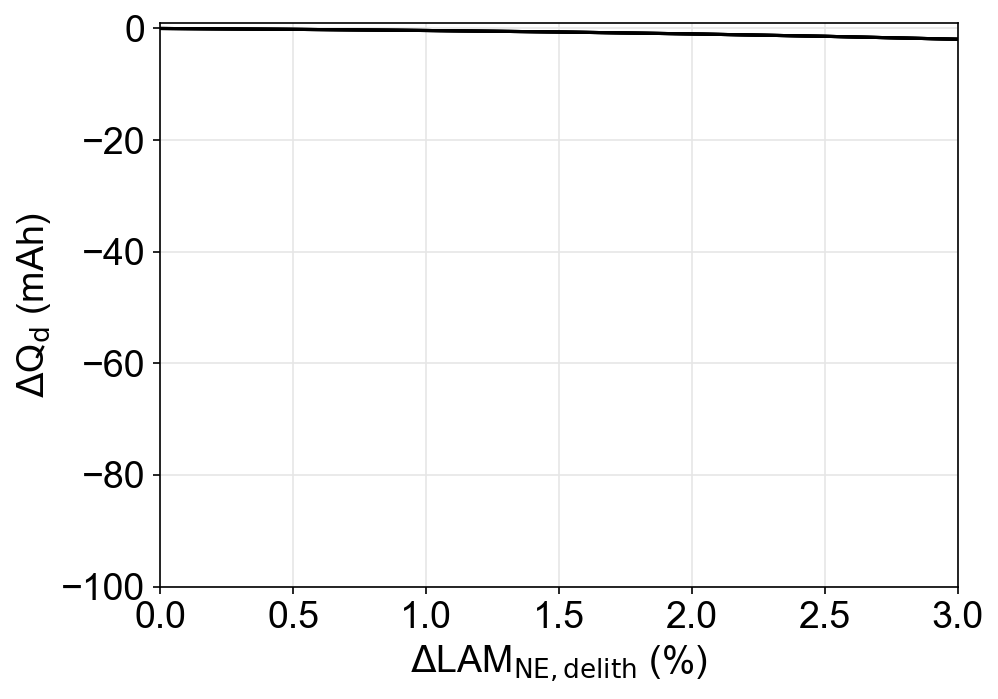

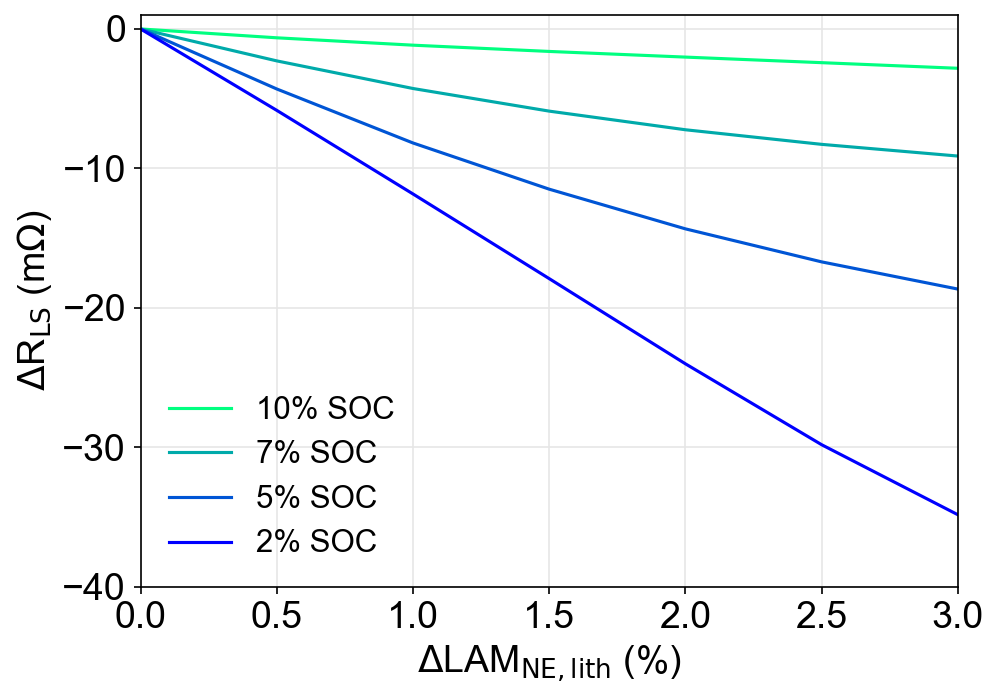

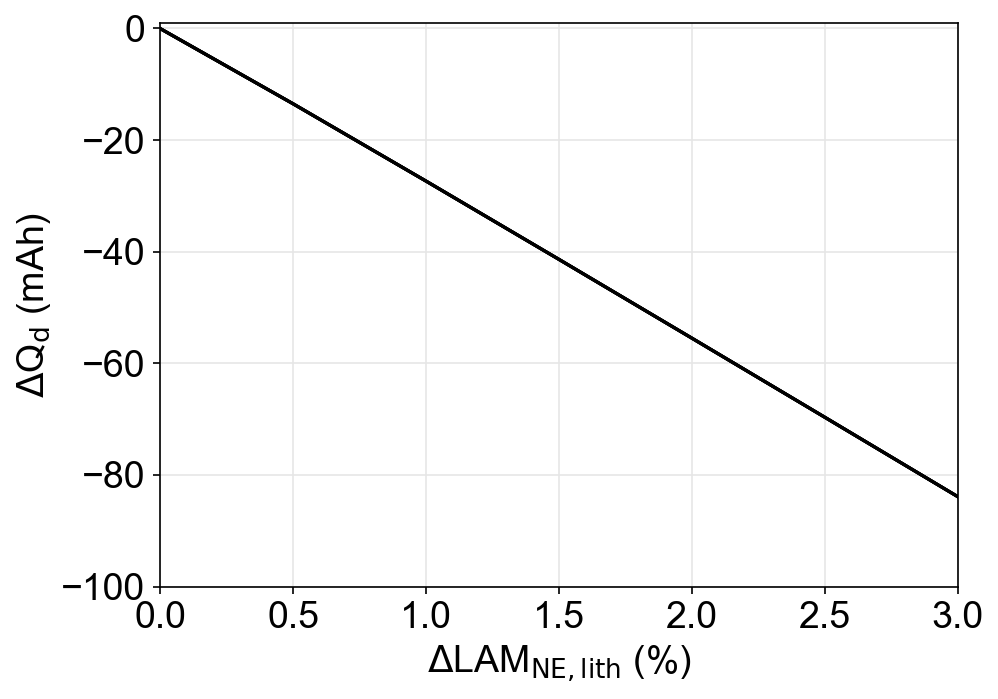

In [26]:
shift_ah = 0

neg_shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

top_or_bottom_vec = ['top', 'bottom']

for top_or_bottom in top_or_bottom_vec:
    
    top_bottom_str = 'lith' if top_or_bottom == 'bottom' else 'delith'

    plt.figure()
    ax1 = plt.gca()

    plt.figure()
    ax2 = plt.gca()

    for i, target_soc in reversed(list(enumerate(target_soc_vec))):

        metrics_orig = compute_useful_metrics(res_orig, target_soc)

        res_target_soc_vec = []
        cell_cap_vec = []

        for neg_shrink_frac in neg_shrink_frac_vec:

            res = voltage_resistance_transform(res_orig, shift_ah,
                                              neg_shrink_loc=top_or_bottom,
                                              neg_shrink_frac=neg_shrink_frac)

            metrics = compute_useful_metrics(res, target_soc)

            res_target_soc_vec.append(metrics['resistance_at_target_soc'])
            cell_cap_vec.append(metrics['cell_cap'])

        res_target_soc_vec = np.array(res_target_soc_vec)
        cell_cap_vec = np.array(cell_cap_vec)

        ax1.plot(neg_shrink_frac_vec * 100, (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
                label=f'{target_soc * 100 :.0f}% SOC',
                 color=colors[i])

        ax1.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{NE, {top_bottom_str}}}}}$ (%)')
        ax1.set_ylabel('$\Delta$R$_\mathrm{LS}$ (m$\Omega$)')
        ax1.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
        ax1.set_ylim((-40, 1))
        ax1.grid(True, color=(0.9, 0.9, 0.9))


        x = neg_shrink_frac_vec * 100
        y = (cell_cap_vec - metrics_orig['cell_cap']) * 1000
        
        ax2.plot(x, y, color='k')
        ax2.set_xlabel(f'$\Delta$LAM$_{{\mathrm{{NE, {top_bottom_str}}}}}$ (%)')
        ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
        ax2.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
        ax2.set_ylim((-100, 1))
        ax2.grid(True, color=(0.9, 0.9, 0.9))


    ax1.legend(prop={'size': 15}, frameon=False)

# Compare the different LAM sensitivities

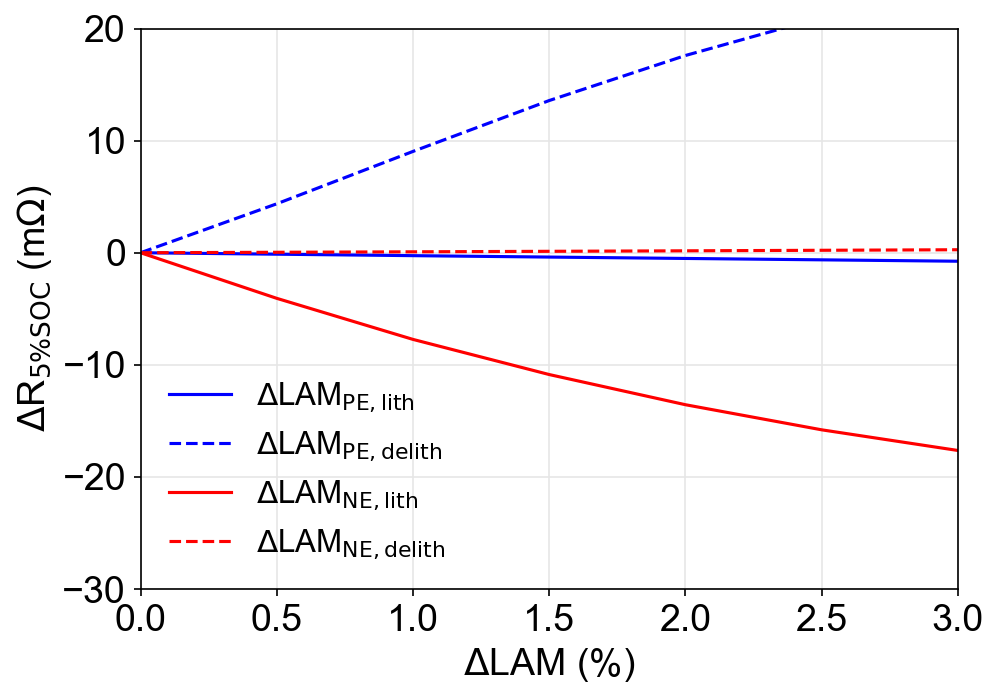

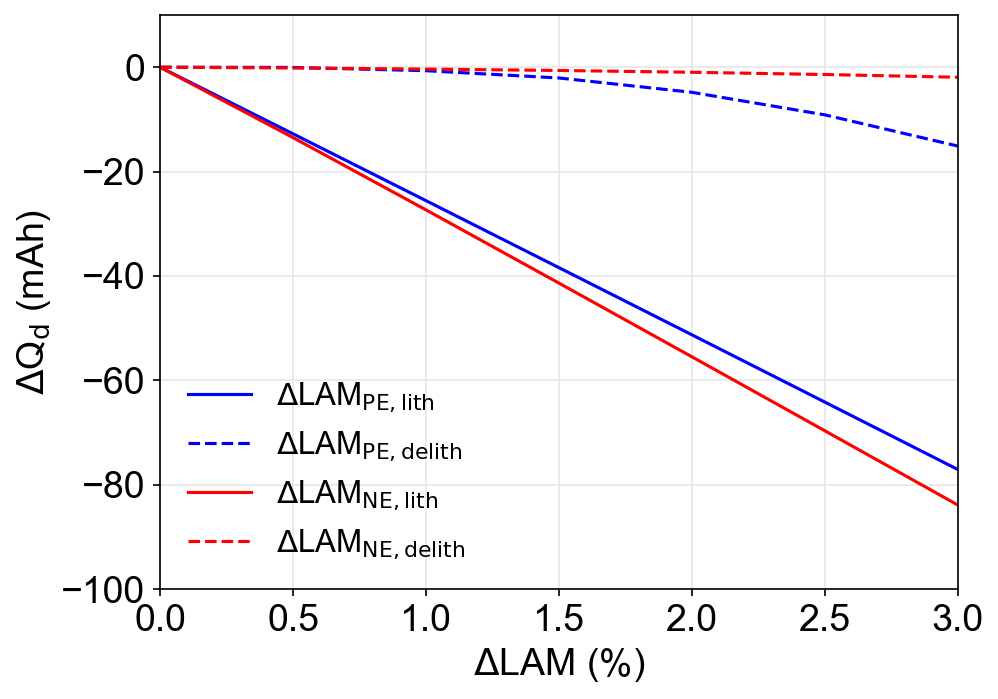

In [29]:
shift_ah = 0
target_soc = 0.05

shrink_frac_vec = np.array([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.030])

lam_type_vec = ['lampe', 'lampe', 'lamne', 'lamne']
top_or_bottom_vec = ['top', 'bottom', 'bottom', 'top']
label_vec = ['$\Delta$LAM$_{{\mathrm{{PE,lith}}}}$', 
             '$\Delta$LAM$_{{\mathrm{{PE,delith}}}}$',
             '$\Delta$LAM$_{{\mathrm{{NE,lith}}}}$',
             '$\Delta$LAM$_{{\mathrm{{NE,delith}}}}$']
colors_vec = ['b', 'b', 'r', 'r']
linestyle_vec = ['-', '--', '-', '--']

plt.figure()
ax1 = plt.gca()

plt.figure()
ax2 = plt.gca()

for (lam_type, top_or_bottom, label, color, linestyle) in \
zip(lam_type_vec, top_or_bottom_vec, label_vec, colors_vec, linestyle_vec):

    metrics_orig = compute_useful_metrics(res_orig, target_soc)

    res_target_soc_vec = []
    cell_cap_vec = []

    for shrink_frac in shrink_frac_vec:

        if lam_type == 'lampe':
            
            res = voltage_resistance_transform(res_orig, shift_ah,
                                              pos_shrink_loc=top_or_bottom,
                                              pos_shrink_frac=shrink_frac)

        elif lam_type == 'lamne':
            
            res = voltage_resistance_transform(res_orig, shift_ah,
                                              neg_shrink_loc=top_or_bottom,
                                              neg_shrink_frac=shrink_frac)
            
        metrics = compute_useful_metrics(res, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    ax1.plot(neg_shrink_frac_vec * 100, 
            (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000,
            label=label,
            color=color,
            linestyle=linestyle)
    
    ax2.plot(neg_shrink_frac_vec * 100, 
            (cell_cap_vec - metrics_orig['cell_cap']) * 1000,
            color=color, linestyle=linestyle,
            label=label)

ax1.set_xlabel('$\Delta$LAM (%)')
ax1.set_ylabel(f'$\Delta$R$_{{{target_soc * 100:.0f}\% \mathrm{{SOC}}}}$ (m$\Omega$)')
ax1.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
ax1.set_ylim((-30, 20))
ax1.grid(True, color=(0.9, 0.9, 0.9))


ax2.set_xlabel('$\Delta$LAM (%)')
ax2.set_ylabel('$\Delta$Q$_\mathrm{d}$ (mAh)')
ax2.set_xlim(np.min(neg_shrink_frac_vec) * 100, np.max(neg_shrink_frac_vec) * 100)
ax2.set_ylim((-100, 10))
ax2.grid(True, color=(0.9, 0.9, 0.9))


ax1.legend(prop={'size': 15}, frameon=False)
ax2.legend(prop={'size': 15}, frameon=False)

# Impact of fraction of resistance from cathode (assuming proportional split)

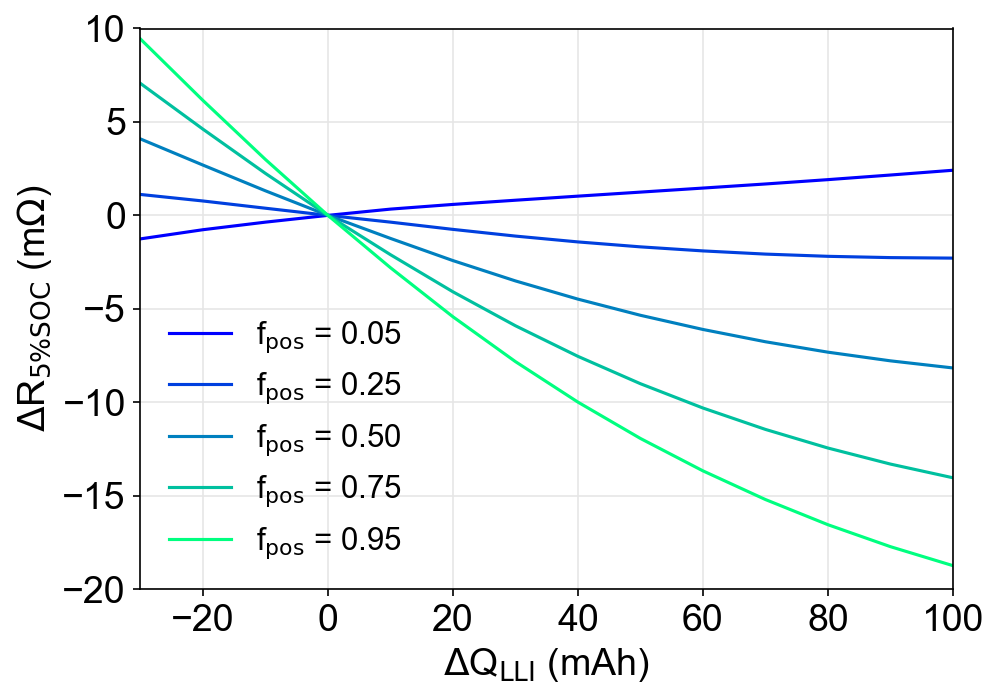

In [28]:


frac_cathode_resistance_vec = np.array([0.05, 0.25, 0.50, 0.75, 0.95])

color_vec = plt.cm.winter(np.linspace(0, 1, len(frac_cathode_resistance_vec)))

target_soc = 0.05

shift_ah_vec = np.arange(-0.1, 0.031, 0.01)

plt.figure()
ax1 = plt.gca()

for i, frac_cathode_resistance in enumerate(frac_cathode_resistance_vec):

    res_orig = fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3,
                                               resistance_curves_type='split',
                                               frac_cathode_resistance=frac_cathode_resistance)

    metrics_orig = compute_useful_metrics(res_orig, target_soc)



    res_target_soc_vec = []
    cell_cap_vec = []

    for shift_ah in shift_ah_vec:

        res = voltage_resistance_transform(res_orig, shift_ah)

        metrics = compute_useful_metrics(res, target_soc)

        res_target_soc_vec.append(metrics['resistance_at_target_soc'])
        cell_cap_vec.append(metrics['cell_cap'])

    res_target_soc_vec = np.array(res_target_soc_vec)
    cell_cap_vec = np.array(cell_cap_vec)

    delta_qlli = -shift_ah_vec

    x = delta_qlli * 1000
    y = (res_target_soc_vec - metrics_orig['resistance_at_target_soc']) * 1000

    ax1.plot(x, y,
             label=f'f$_\mathrm{{pos}}$ = {frac_cathode_resistance :.2f}',
             color=color_vec[i])

# Plot noise in the RLS measuremet converted to QLLI estimation inaccuracy
ax1.set_xlabel('$\Delta$Q$_{\mathrm{LLI}}$ (mAh)')
ax1.set_ylabel('$\Delta$R$_\mathrm{5\% SOC}$ (m$\Omega$)')
ax1.set_xlim(np.min(delta_qlli) * 1000, np.max(delta_qlli) * 1000)
ax1.set_ylim((-20, 10))
ax1.grid(True, color=(0.9, 0.9, 0.9))
ax1.legend(prop={'size': 15}, frameon=False)